In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('new_data.csv').dropna(subset=['Text'])

print(len(df.index))
df['Text'].head()


91928


0    When the coworkers compliment you on how skinn...
1    Shape up this summer with @QLuxSpa! #waisttrai...
2    How to remove 400 #calories from your #diet wi...
3    Heartburn Acid Reflux &amp; GERD Diet Cure Wit...
4    David Zinczenko - the "Abs Diet" and "Zero Bel...
Name: Text, dtype: object

In [4]:
import preprocessor as p

df['clean_text'] = df['Text'].apply(lambda text: p.clean(str(text)))

df['clean_text'].head()

0    When the coworkers compliment you on how skinn...
1                          Shape up this summer with !
2              How to remove from your without effort?
3    Heartburn Acid Reflux &amp; GERD Diet Cure Wit...
4    David Zinczenko - the "Abs Diet" and "Zero Bel...
Name: clean_text, dtype: object

In [5]:
df.sort_values("Text", inplace = True)
# dropping ALL duplicte values
df.drop_duplicates(subset ="Text",keep = False, inplace = True)

In [6]:
df['clean_text'] = df['clean_text'].apply(lambda text: text.lower())

df['clean_text'].head()

34046                                     !dile a la ! ...
20327    " eating good , looking good , feeling good an...
84720            " fat kat, they call tht bitch garfield "
63664    " how are you going to exercise that decree wi...
53235      " i exercise at length so electrify the fence."
Name: clean_text, dtype: object

In [7]:
import re

def remove_contractions(text):
    text = re.sub(r'’', '\'', text)
    
    text = re.sub(r'won\'t', 'will not', text)
    text = re.sub(r'can\'t', 'can not', text)
    
    text = re.sub(r'\'s', ' is', text)
    text = re.sub(r'\'m', ' am', text)
    text = re.sub(r'\'re', ' are', text)
    text = re.sub(r'\'ve', ' have', text)
    text = re.sub(r'\'ll', ' will', text)
    text = re.sub(r'\'d', ' would', text)
    text = re.sub(r'\'t', ' not', text)
    text = re.sub(r'n\'t', ' not', text)
    
    return text

df['clean_text'] = df['clean_text'].apply(remove_contractions)

df['clean_text'].head()

34046                                     !dile a la ! ...
20327    " eating good , looking good , feeling good an...
84720            " fat kat, they call tht bitch garfield "
63664    " how are you going to exercise that decree wi...
53235      " i exercise at length so electrify the fence."
Name: clean_text, dtype: object

In [8]:
df['clean_text'] = df['clean_text'].str.replace('[^\w\s]', '')

df['clean_text'].head()

C:\Users\panka\AppData\Local\Temp\ipykernel_1028\3609691566.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text'] = df['clean_text'].str.replace('[^\w\s]', '')


34046                                          dile a la  
20327     eating good  looking good  feeling good and i...
84720                fat kat they call tht bitch garfield 
63664     how are you going to exercise that decree win...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [9]:
# Remove whitespaces.

df['clean_text'] = df['clean_text'].apply(lambda text: str(text).strip())

df['clean_text'].head()

34046                                            dile a la
20327    eating good  looking good  feeling good and it...
84720                 fat kat they call tht bitch garfield
63664    how are you going to exercise that decree wine...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [10]:
# Remove empty texts.

df = df.drop(df[df['clean_text'] == ''].index)

print(len(df.index))
df['clean_text'].head()

65003


34046                                            dile a la
20327    eating good  looking good  feeling good and it...
84720                 fat kat they call tht bitch garfield
63664    how are you going to exercise that decree wine...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [11]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\panka\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [12]:
# Remove non-English words.
from nltk.corpus import words
words = set(words.words())

df['clean_text'] = df['clean_text'].apply(lambda text: ' '.join(word for word in text.split() if word in words))

df['clean_text'].head()

34046                                                 a la
20327    eating good looking good feeling good and it i...
84720                              fat kat they call bitch
63664    how are you going to exercise that decree wine...
53235          i exercise at length so electrify the fence
Name: clean_text, dtype: object

In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [14]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(df['clean_text']))

In [15]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) 
   if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

In [17]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [18]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

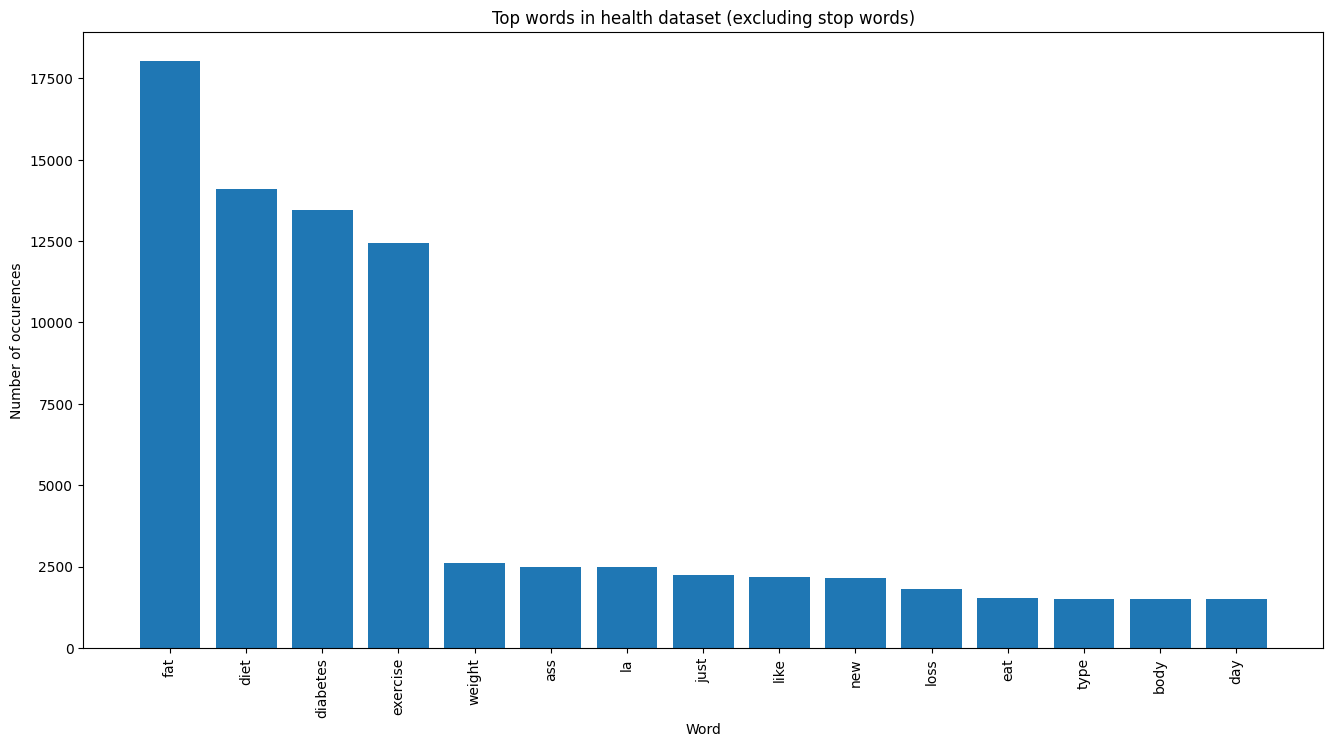

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in health dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [20]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(corpus)
corpus = vectorizer.transform(corpus)

NameError: name 'feature_extraction' is not defined

In [21]:
lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=corpus, id2word=id2word, num_topics=20,chunksize=100
)

KeyboardInterrupt: 

In [ ]:
pprint(lsi_model.print_topics())
doc_lsi = lsi_model[corpus]

[(0,
  '0.898*"fat" + 0.231*"exercise" + 0.196*"get" + 0.121*"diet" + 0.086*"ass" + '
  '0.080*"lose" + 0.073*"eat" + 0.069*"loss" + 0.068*"weight" + 0.068*"body"'),
 (1,
  '0.924*"exercise" + -0.303*"fat" + 0.108*"diet" + 0.073*"new" + 0.054*"good" '
  '+ 0.053*"get" + 0.048*"weight" + 0.039*"day" + 0.038*"time" + 0.037*"eat"'),
 (2,
  '0.932*"diet" + -0.195*"exercise" + -0.143*"fat" + 0.116*"weight" + '
  '0.096*"eat" + 0.075*"high" + 0.068*"blood_pressure" + 0.059*"loss" + '
  '0.058*"healthy" + 0.057*"lose"'),
 (3,
  '-0.862*"diabete" + -0.411*"diabetes" + -0.187*"type" + 0.095*"diet" + '
  '-0.066*"get" + -0.060*"health" + -0.054*"heart_disease" + 0.050*"exercise" '
  '+ -0.048*"new" + -0.040*"risk"'),
 (4,
  '0.882*"diabetes" + -0.447*"diabete" + 0.103*"get" + 0.028*"type" + '
  '0.028*"association" + 0.027*"tech" + 0.027*"help" + -0.024*"fat" + '
  '-0.023*"weight" + 0.021*"breakthrough"'),
 (5,
  '0.722*"get" + -0.511*"weight" + -0.327*"loss" + -0.243*"lose" + '
  '-0.107*"diab

In [ ]:
#print('\nPerplexity: ', lsi_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)


Coherence Score:  0.3495677568429962


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.lsimodel.LsiModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=600, step=4)

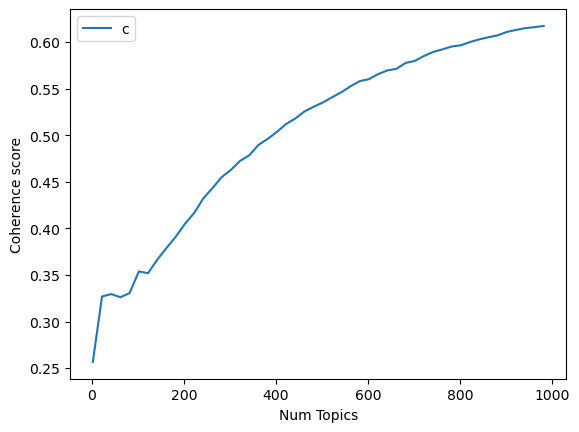

In [ ]:
limit=1000; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2566
Num Topics = 22  has Coherence Value of 0.3269
Num Topics = 42  has Coherence Value of 0.3294
Num Topics = 62  has Coherence Value of 0.326
Num Topics = 82  has Coherence Value of 0.3305
Num Topics = 102  has Coherence Value of 0.3538
Num Topics = 122  has Coherence Value of 0.3519
Num Topics = 142  has Coherence Value of 0.3664
Num Topics = 162  has Coherence Value of 0.3788
Num Topics = 182  has Coherence Value of 0.3909
Num Topics = 202  has Coherence Value of 0.4047
Num Topics = 222  has Coherence Value of 0.4162
Num Topics = 242  has Coherence Value of 0.432
Num Topics = 262  has Coherence Value of 0.4432
Num Topics = 282  has Coherence Value of 0.4549
Num Topics = 302  has Coherence Value of 0.4627
Num Topics = 322  has Coherence Value of 0.4724
Num Topics = 342  has Coherence Value of 0.4784
Num Topics = 362  has Coherence Value of 0.4895
Num Topics = 382  has Coherence Value of 0.496
Num Topics = 402  has Coherence Value of 0.5035
N

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.899*"fat" + 0.231*"exercise" + 0.195*"get" + 0.123*"diet" + 0.086*"ass" + '
  '0.080*"lose" + 0.072*"eat" + 0.069*"weight" + 0.069*"loss" + 0.068*"body"'),
 (1,
  '0.924*"exercise" + -0.303*"fat" + 0.112*"diet" + 0.073*"new" + 0.054*"good" '
  '+ 0.052*"get" + 0.048*"weight" + 0.038*"day" + 0.037*"time" + 0.037*"eat"'),
 (2,
  '0.933*"diet" + -0.197*"exercise" + -0.142*"fat" + 0.115*"weight" + '
  '0.093*"eat" + 0.075*"high" + 0.066*"blood_pressure" + 0.057*"loss" + '
  '0.056*"lose" + 0.054*"healthy"'),
 (3,
  '0.860*"diabete" + 0.425*"diabetes" + 0.181*"type" + -0.094*"diet" + '
  '0.061*"get" + 0.058*"health" + -0.049*"exercise" + 0.048*"heart_disease" + '
  '0.046*"new" + -0.037*"fat"'),
 (4,
  '0.882*"diabetes" + -0.455*"diabete" + 0.079*"get" + 0.026*"help" + '
  '0.025*"tech" + 0.025*"association" + 0.022*"type" + 0.020*"tell" + '
  '-0.020*"fat" + 0.019*"breakthrough"'),
 (5,
  '0.760*"get" + -0.479*"weight" + -0.300*"loss" + -0.235*"lose" + '
  '-0.089*"diabetes" + -